In [1]:
import os
import torch
import numpy as np
from torch.autograd import Variable
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from mxtorch import transforms as tfs
from torchvision.transforms import RandomCrop 
from torchvision import transforms 
from datetime import datetime
import random
import matplotlib.pyplot as plt
%matplotlib inline

/home/yang/anaconda2/envs/python3/lib/python3.5/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.22) or chardet (2.3.0) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
colormap = ((128, 128, 128), (128, 0, 0), (128, 64, 128), (0, 0, 192), (64, 64, 128),
                (128, 128, 0), (192, 192, 128), (64, 0, 128), (192, 128, 128), (64, 64, 0),
                (0, 128, 192), (0, 0, 0))
im_show1 = Image.open('../../kitti_seg/train/rgb/00_000000.png')
label_show1 = Image.open('../../kitti_seg/train/labels/00_000000.png').convert('RGB')
im_show2 = Image.open('../../kitti_seg/train/rgb/00_000000.png')
label_show2 = Image.open('../../kitti_seg/train/semantics/00_000000.png')

cm = np.array(colormap).astype('uint8')
label_show2  = cm[label_show2 ]

(1241, 376)
(1241, 376)


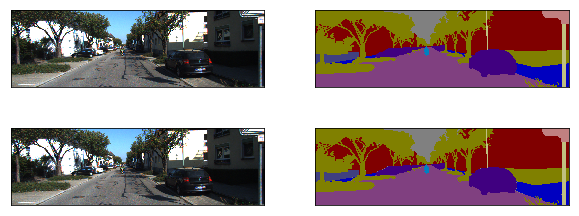

In [3]:
_, figs = plt.subplots(2, 2, figsize=(10, 4))
figs[0][0].imshow(im_show1)
figs[0][0].axes.get_xaxis().set_visible(False)
figs[0][0].axes.get_yaxis().set_visible(False)
figs[0][1].imshow(label_show1)
figs[0][1].axes.get_xaxis().set_visible(False)
figs[0][1].axes.get_yaxis().set_visible(False)
figs[1][0].imshow(im_show2)
figs[1][0].axes.get_xaxis().set_visible(False)
figs[1][0].axes.get_yaxis().set_visible(False)
figs[1][1].imshow(label_show2)
figs[1][1].axes.get_xaxis().set_visible(False)
figs[1][1].axes.get_yaxis().set_visible(False)
print(im_show1.size)
print(im_show2.size)

In [4]:
import os
def file_name(file_dir): 
    list_file_names = []
    os.walk(file_dir)
    for root, dirs, files in os.walk(file_dir):
         pass
    return files#当前路径下所有非目录子文件

In [5]:
list_file_names  = file_name('../../kitti_seg/train/rgb')
f = open('./filenames/train.txt', 'w')
for name in list_file_names[:245]:
    fname = str(name) +'\n'
    f.write(fname)
f.close()

In [6]:
list_file_names  = file_name('../../kitti_seg/test/rgb')
f = open('./filenames/test.txt', 'w')
for name in list_file_names[:49]:
    fname = str(name) +'\n'
    f.write(fname)
f.close()

In [7]:
list_file_names  = file_name('../../kitti_seg/train/rgb')
f = open('./filenames/valid.txt', 'w')
for name in list_file_names[245:345]:
    fname = str(name) +'\n'
    f.write(fname)
f.close()

In [8]:
def random_crop(size,img_src,img_label):
    w, h = img_src.size
    th, tw = size
    x1 = random.randint(0, w - tw)
    y1 = random.randint(0, h - th)
    
    img_src= img_src.crop((x1, y1, x1 + tw, y1 + th))
    img_label = img_label.crop((x1, y1, x1 + tw, y1 + th))

    return img_src,img_label

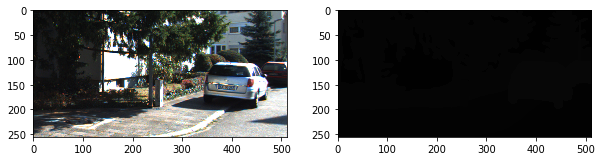

In [9]:
img_src = Image.open('../../kitti_seg/train/rgb/00_000200.png')
img_label = Image.open('../../kitti_seg/train/semantics/00_000200.png')
crop_src,crop_label = random_crop((256,512),img_src,img_label)

_, figs = plt.subplots(1, 2, figsize=(10, 4))
figs[0].imshow(crop_src)
figs[1].imshow(crop_label)


In [10]:
num_classes = 12
full_to_train = {-1: 19, 0: 19, 1: 19, 2: 19, 3: 19, 4: 19, 5: 19, 6: 19, 7: 0, 8: 1, 9: 19, 10: 19, 11: 2, 12: 3, 13: 4, 14: 19, 15: 19, 16: 19, 17: 5, 18: 19, 19: 6, 20: 7, 21: 8, 22: 9, 23: 10, 24: 11, 25: 12, 26: 13, 27: 14, 28: 15, 29: 19, 30: 19, 31: 16, 32: 17, 33: 18}
train_to_full = {0: 7, 1: 8, 2: 11, 3: 12, 4: 13, 5: 17, 6: 19, 7: 20, 8: 21, 9: 22, 10: 23, 11: 24, 12: 25, 13: 26, 14: 27, 15: 28, 16: 31, 17: 32, 18: 33, 19: 0}
colormap = ((128, 128, 128), (128, 0, 0), (128, 64, 128), (0, 0, 192), (64, 64, 128),
                (128, 128, 0), (192, 192, 128), (64, 0, 128), (192, 128, 128), (64, 64, 0),
                (0, 128, 192), (0, 0, 0))
'''
128 64 128
sidewalk
0 0 192
fence
64 64 128
vegetation
128 128 0
pole
192 192 128
car
64 0 128
sign
192 128 128
pedestrian
64 64 0
cyclist
0 128 192
ignore
0 0 0
'''
full_to_colour = {0: (0, 0, 0), 7: (128, 64, 128), 8: (244, 35, 232), 11: (70, 70, 70), 12: (102, 102, 156), 13: (190, 153, 153), 17: (153, 153, 153), 19: (250, 170, 30), 20: (220, 220, 0), 21: (107, 142, 35), 22: (152, 251, 152), 23: (70, 130, 180), 24: (220, 20, 60), 25: (255, 0, 0), 26: (0, 0, 142), 27: (0, 0, 70), 28: (0, 60,100), 31: (0, 80, 100), 32: (0, 0, 230), 33: (119, 11, 32)}
print(len(full_to_colour))

20


In [11]:
def image2label(img_label):
    return np.array(img_label,dtype='int64')

def img_transforms(img, label, crop_size):
    img, label = random_crop(crop_size,img, label)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])

    img = transform(img)
    #label = image2label(label)
    label = image2label(label)
    #print(np.max(label),np.min(label))
    
    label = torch.from_numpy(label)
    return img, label

In [12]:
filenames_path = './filenames/'
data_path = '../../kitti_seg/'

def read_images(data_path,filenames_path, train=True, valid = False):
    if valid:
        txt_fname = filenames_path + 'valid.txt'
    else:  
        txt_fname = filenames_path + ('train.txt' if train else 'test.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    if valid:
        data = [os.path.join(data_path, 'train/rgb/', i) for i in images]
        label = [os.path.join(data_path,'train/semantics/', i) for i in images]
    elif train == True:
        data = [os.path.join(data_path, 'train/rgb/', i) for i in images]
        label = [os.path.join(data_path,'train/semantics/', i) for i in images]
    else:
        data = [os.path.join(data_path, 'test/rgb/', i) for i in images]
        label = [os.path.join(data_path,'test/semantics/', i) for i in images]
    return data, label
    

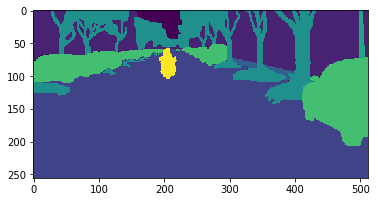

In [13]:

img_src = Image.open('../../kitti_seg/train/rgb/00_000000.png')
img_label = Image.open('../../kitti_seg/train/semantics/00_000000.png')

img,label = img_transforms(img_src,img_label,(256,512))
plt.imshow(label)

In [14]:
'''def kitti2label(img_label):
    img_label = np.array(img_label)
    class_name = ('sky', 'building', 'road', 'sidewalk', 'fence',
                  'vegetation', 'pole', 'car', 'sign', 'pedestrian',
                  'cyclist', 'ignore')
    class_color = ((128, 128, 128), (128, 0, 0), (128, 64, 128), (0, 0, 192), (64, 64, 128),
                    (128, 128, 0), (192, 192, 128), (64, 0, 128), (192, 128, 128), (64, 64, 0),
                    (0, 128, 192), (0, 0, 0))
    
    height, width, channel = img_label.shape
    
    cvt_label = np.zeros([height,width])
    
    for i in range(height):
        for j in range(width):
            
            try:
                cvt_label[i][j] = class_color.index(tuple(img_label[i][j]))  # some images are RGBA but some are RGB
            except:  # few pixel values not follow the defined labels above.
                cvt_label[i][j] = 0 # it is not good yet
    return cvt_label.astype(np.uint8)
'''

"def kitti2label(img_label):\n    img_label = np.array(img_label)\n    class_name = ('sky', 'building', 'road', 'sidewalk', 'fence',\n                  'vegetation', 'pole', 'car', 'sign', 'pedestrian',\n                  'cyclist', 'ignore')\n    class_color = ((128, 128, 128), (128, 0, 0), (128, 64, 128), (0, 0, 192), (64, 64, 128),\n                    (128, 128, 0), (192, 192, 128), (64, 0, 128), (192, 128, 128), (64, 64, 0),\n                    (0, 128, 192), (0, 0, 0))\n    \n    height, width, channel = img_label.shape\n    \n    cvt_label = np.zeros([height,width])\n    \n    for i in range(height):\n        for j in range(width):\n            \n            try:\n                cvt_label[i][j] = class_color.index(tuple(img_label[i][j]))  # some images are RGBA but some are RGB\n            except:  # few pixel values not follow the defined labels above.\n                cvt_label[i][j] = 0 # it is not good yet\n    return cvt_label.astype(np.uint8)\n"

In [15]:
'''
data_list,label_list = read_images(data_path,filenames_path, False)
for id,file_label in enumerate(label_list): 
    print(id,file_label)
    
    img_label = Image.open(file_label).convert('RGB')
    cvt_label = kitti2label(img_label)
    im = Image.fromarray(cvt_label)
    im.save('../'+file_label)
    #plt.imshow(cvt_label)
   # plt.show()
'''

"\ndata_list,label_list = read_images(data_path,filenames_path, False)\nfor id,file_label in enumerate(label_list): \n    print(id,file_label)\n    \n    img_label = Image.open(file_label).convert('RGB')\n    cvt_label = kitti2label(img_label)\n    im = Image.fromarray(cvt_label)\n    im.save('../'+file_label)\n    #plt.imshow(cvt_label)\n   # plt.show()\n"

In [16]:
img_label = Image.open('../../kitti_seg/train/semantics/10_000725.png')

#imagekitti2label(img_label)

#img_label[150:160, 240:250]

In [17]:
class KittiSegDataset(Dataset):
    
    def __init__(self, data_path, filenames_path,train,valid, crop_size, transforms):
        self.crop_size = crop_size
        self.transforms = transforms
        self.data_list, self.label_list = read_images(data_path,filenames_path,train,valid)
        print('Read ' + str(len(self.data_list)) + ' images')
        #print(self.data_list)

    def __getitem__(self, idx):
        img = self.data_list[idx]
        label = self.label_list[idx]
        img = Image.open(img)
        label = Image.open(label)#.convert('RGB')
        img, label = self.transforms(img, label, self.crop_size)
        return img, label
    
    def __len__(self):
        return len(self.data_list)

下面我们可以验证一下随机 crop

In [18]:
#Construct dataset
input_shape = (256,512)
kitti_train = KittiSegDataset(data_path,filenames_path,  True,False, input_shape, img_transforms)
kitti_valid  = KittiSegDataset(data_path,filenames_path,  False, False,input_shape, img_transforms)
kitti_test  = KittiSegDataset(data_path,filenames_path,  False,True, input_shape, img_transforms)

train_data = DataLoader(kitti_train, 10, shuffle=True, num_workers=4)
valid_data = DataLoader(kitti_valid, 1, num_workers=4)
test_data = DataLoader(kitti_test, 1, num_workers=4)


Read 245 images
Read 46 images
Read 100 images


In [19]:
x = torch.randn(1, 3, 120, 120)
conv_trans = nn.ConvTranspose2d(3, 10, 4, stride=2, padding=1)
y = conv_trans(Variable(x))
print(y.shape)

torch.Size([1, 10, 240, 240])


In [20]:
# 定义 bilinear kernel
def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''
    return a bilinear filter tensor
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

(375, 1242, 3)


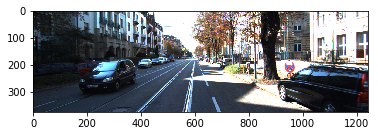

In [21]:
x = Image.open('../../kitti/training/image_2/000000_10.png')
x = np.array(x)
plt.imshow(x)
print(x.shape)

(750, 2484, 3)


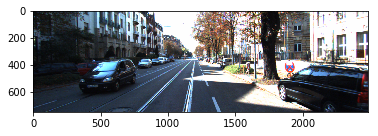

In [22]:
x = torch.from_numpy(x.astype('float32')).permute(2, 0, 1).unsqueeze(0)
# 定义转置卷积
conv_trans = nn.ConvTranspose2d(3, 3, 4, 2, 1)
# 将其定义为 bilinear kernel
conv_trans.weight.data = bilinear_kernel(3, 3, 4)

y = conv_trans(Variable(x)).data.squeeze().permute(1, 2, 0).numpy()
plt.imshow(y.astype('uint8'))
print(y.shape)

In [23]:
import torchvision.models as models

In [24]:
# pretrained resnet 34
pretrained_net = models.resnet34(pretrained=True)

In [25]:
#print(pretrained_net)

In [26]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4]) # 第一段
        self.stage2 = list(pretrained_net.children())[-4] # 第二段
        self.stage3 = list(pretrained_net.children())[-3] # 第三段
        
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)
        
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, 16, 8, 4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16) # 使用双线性 kernel
        
        self.upsample_4x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)
        self.upsample_4x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel
        
        self.upsample_2x = nn.ConvTranspose2d(num_classes, num_classes, 4, 2, 1, bias=False)   
        self.upsample_2x.weight.data = bilinear_kernel(num_classes, num_classes, 4) # 使用双线性 kernel

        
    def forward(self, x):
        x = self.stage1(x)
        s1 = x # 1/8
        
        x = self.stage2(x)
        s2 = x # 1/16
        
        x = self.stage3(x)
        s3 = x # 1/32
        
        s3 = self.scores1(s3)
        s3 = self.upsample_2x(s3)
        s2 = self.scores2(s2)
        s2 = s2 + s3
        
        s1 = self.scores3(s1)
        s2 = self.upsample_4x(s2)
        s = s1 + s2

        s = self.upsample_8x(s)
        return s

In [27]:
class SegNet(nn.Module):
    def __init__(self,input_nbr,label_nbr):
        super(SegNet, self).__init__()

        batchNorm_momentum = 0.1

        self.conv11 = nn.Conv2d(input_nbr, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33 = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53 = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv53d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn53d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv52d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn52d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv51d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn51d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)

        self.conv43d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn43d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv42d = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42d = nn.BatchNorm2d(512, momentum= batchNorm_momentum)
        self.conv41d = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn41d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)

        self.conv33d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn33d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv32d = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32d = nn.BatchNorm2d(256, momentum= batchNorm_momentum)
        self.conv31d = nn.Conv2d(256,  128, kernel_size=3, padding=1)
        self.bn31d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)

        self.conv22d = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22d = nn.BatchNorm2d(128, momentum= batchNorm_momentum)
        self.conv21d = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn21d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)

        self.conv12d = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12d = nn.BatchNorm2d(64, momentum= batchNorm_momentum)
        self.conv11d = nn.Conv2d(64, label_nbr, kernel_size=3, padding=1)


    def forward(self, x):

        # Stage 1
        x11 = F.relu(self.bn11(self.conv11(x)))
        x12 = F.relu(self.bn12(self.conv12(x11)))
        x1p, id1 = F.max_pool2d(x12,kernel_size=2, stride=2,return_indices=True)

        # Stage 2
        x21 = F.relu(self.bn21(self.conv21(x1p)))
        x22 = F.relu(self.bn22(self.conv22(x21)))
        x2p, id2 = F.max_pool2d(x22,kernel_size=2, stride=2,return_indices=True)

        # Stage 3
        x31 = F.relu(self.bn31(self.conv31(x2p)))
        x32 = F.relu(self.bn32(self.conv32(x31)))
        x33 = F.relu(self.bn33(self.conv33(x32)))
        x3p, id3 = F.max_pool2d(x33,kernel_size=2, stride=2,return_indices=True)

        # Stage 4
        x41 = F.relu(self.bn41(self.conv41(x3p)))
        x42 = F.relu(self.bn42(self.conv42(x41)))
        x43 = F.relu(self.bn43(self.conv43(x42)))
        x4p, id4 = F.max_pool2d(x43,kernel_size=2, stride=2,return_indices=True)

        # Stage 5
        x51 = F.relu(self.bn51(self.conv51(x4p)))
        x52 = F.relu(self.bn52(self.conv52(x51)))
        x53 = F.relu(self.bn53(self.conv53(x52)))
        x5p, id5 = F.max_pool2d(x53,kernel_size=2, stride=2,return_indices=True)


        # Stage 5d
        x5d = F.max_unpool2d(x5p, id5, kernel_size=2, stride=2)
        x53d = F.relu(self.bn53d(self.conv53d(x5d)))
        x52d = F.relu(self.bn52d(self.conv52d(x53d)))
        x51d = F.relu(self.bn51d(self.conv51d(x52d)))

        # Stage 4d
        x4d = F.max_unpool2d(x51d, id4, kernel_size=2, stride=2)
        x43d = F.relu(self.bn43d(self.conv43d(x4d)))
        x42d = F.relu(self.bn42d(self.conv42d(x43d)))
        x41d = F.relu(self.bn41d(self.conv41d(x42d)))

        # Stage 3d
        x3d = F.max_unpool2d(x41d, id3, kernel_size=2, stride=2)
        x33d = F.relu(self.bn33d(self.conv33d(x3d)))
        x32d = F.relu(self.bn32d(self.conv32d(x33d)))
        x31d = F.relu(self.bn31d(self.conv31d(x32d)))

        # Stage 2d
        x2d = F.max_unpool2d(x31d, id2, kernel_size=2, stride=2)
        x22d = F.relu(self.bn22d(self.conv22d(x2d)))
        x21d = F.relu(self.bn21d(self.conv21d(x22d)))

        # Stage 1d
        x1d = F.max_unpool2d(x21d, id1, kernel_size=2, stride=2)
        x12d = F.relu(self.bn12d(self.conv12d(x1d)))
        x11d = self.conv11d(x12d)

        return x11d

In [28]:
#net = fcn(num_classes)
net = SegNet(3,num_classes)
net = net.cuda()

In [29]:
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [30]:
from eval_semantic_segmentation import *

In [31]:
#  loss  optimizer
import torch.optim as optim

criterion = nn.NLLLoss2d()
#basic_optim = torch.optim.SGD(net.parameters(), lr=1e-2, weight_decay=1e-4)

optimizer = optim.SGD(net.parameters(), lr=0.001,momentum=0.9)

In [32]:
net.load_state_dict(torch.load('segnet.pkl'))


In [33]:
log_loss =list()
log_IOU = list()
#log_acc = list()

log_valid_loss =list()
log_valid_IOU = list()

for e in range(4000):
    #if e > 0 and e % 50 == 0:
    #    optimizer.set_learning_rate(optimizer.learning_rate * 0.1)
    train_loss = 0
    train_acc = 0
    train_mean_iu = 0
    
    prev_time = datetime.now()
    net = net.train()
    for data in train_data:
        im = Variable(data[0].cuda())
        labels = Variable(data[1].cuda())
        

        
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1) # (b, n, h, w)
        
        loss = criterion(out, labels)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.data[0]
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)
        
        train_acc += eval_metrics['mean_class_accuracy']
        train_mean_iu += eval_metrics['miou']
        
    net = net.eval()
    
    eval_loss = 0
    eval_acc = 0
    eval_mean_iu = 0
    for data in valid_data:
        im = Variable(data[0].cuda(), volatile=True)
        labels = Variable(data[1].cuda(), volatile=True)
        # forward
        out = net(im)
        out = F.log_softmax(out, dim=1)
        eval_loss += loss.data[0]
        loss = criterion(out, labels)
        
        
        pred_labels = out.max(dim=1)[1].data.cpu().numpy()
        pred_labels = [i for i in pred_labels]

        true_labels = labels.data.cpu().numpy()
        true_labels = [i for i in true_labels]

        eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)

    eval_acc += eval_metrics['mean_class_accuracy']
    eval_mean_iu += eval_metrics['miou']
    
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, \
Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, train_loss / len(train_data), train_acc / len(train_data), train_mean_iu / len(train_data),
        eval_loss / len(valid_data), eval_acc, eval_mean_iu))
    
    log_loss.append(train_loss / len(train_data))
    log_IOU.append(train_mean_iu / len(train_data))
    log_valid_IOU.append(eval_mean_iu)
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str)#+ ' lr: {}'.format(optimizer.learning_rate))
    torch.save(net.state_dict(), 'segnet.pkl')

Epoch: 0, Train Loss: 1.71178, Train Acc: 0.08824, Train Mean IU: 0.03356, Valid Loss: 1.89372, Valid Acc: 0.10014, Valid Mean IU: 0.02558 Time: 0:1:31
Epoch: 1, Train Loss: 1.65215, Train Acc: 0.11067, Train Mean IU: 0.05120, Valid Loss: 1.75835, Valid Acc: 0.14813, Valid Mean IU: 0.05428 Time: 0:1:31
Epoch: 2, Train Loss: 1.54438, Train Acc: 0.16366, Train Mean IU: 0.08922, Valid Loss: 1.71103, Valid Acc: 0.19725, Valid Mean IU: 0.08508 Time: 0:1:31
Epoch: 3, Train Loss: 1.46081, Train Acc: 0.17137, Train Mean IU: 0.09519, Valid Loss: 1.65782, Valid Acc: 0.19469, Valid Mean IU: 0.09290 Time: 0:1:31
Epoch: 4, Train Loss: 1.41199, Train Acc: 0.17540, Train Mean IU: 0.10092, Valid Loss: 1.75350, Valid Acc: 0.17551, Valid Mean IU: 0.08363 Time: 0:1:31
Epoch: 5, Train Loss: 1.36269, Train Acc: 0.18602, Train Mean IU: 0.11255, Valid Loss: 1.69728, Valid Acc: 0.21590, Valid Mean IU: 0.11148 Time: 0:1:31
Epoch: 6, Train Loss: 1.33061, Train Acc: 0.19785, Train Mean IU: 0.12478, Valid Loss: 1

Process Process-11852:
Process Process-11849:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-11850:
Process Process-11851:
  File "/home/yang/anaconda2/envs/python3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/yang/anaconda2/envs/python3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yang/anaconda2/envs/python3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/yang/anaconda2/envs/python3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/yang/anaconda2/envs/python3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yang/anaconda2/envs/python3/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 50, in _worker_loop
    r = i

KeyboardInterrupt: 

In [43]:
net = net.eval()

eval_loss = 0
eval_acc = 0
eval_mean_iu = 0
for data in test_data:
    im = Variable(data[0].cuda(), volatile=True)
    labels = Variable(data[1].cuda(), volatile=True)
    # forward
    out = net(im)
    out = F.log_softmax(out, dim=1)
    eval_loss += loss.data[0]
    loss = criterion(out, labels)


    pred_labels = out.max(dim=1)[1].data.cpu().numpy()
    pred_labels = [i for i in pred_labels]

    true_labels = labels.data.cpu().numpy()
    true_labels = [i for i in true_labels]

    eval_metrics = eval_semantic_segmentation(pred_labels, true_labels)

eval_acc += eval_metrics['mean_class_accuracy']
eval_mean_iu += eval_metrics['miou']

cur_time = datetime.now()
h, remainder = divmod((cur_time - prev_time).seconds, 3600)
m, s = divmod(remainder, 60)
epoch_str = ('Test Loss: {:.5f}, Test Acc: {:.5f}, Test Mean IU: {:.5f} '.format(eval_loss / len(test_data), eval_acc, eval_mean_iu))


time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
print(epoch_str + time_str)#+ ' lr: {}'.format(optimizer.learning_rate))

Test Loss: 0.51562, Test Acc: 0.69769, Test Mean IU: 0.44455 Time: 9:33:53


In [44]:
# net.load_state_dict(torch.load('./fcn.pth'))
net = net.eval()

In [45]:

cm = np.array(colormap).astype('uint8')
print(len(cm))
def predict(img, label): 
    img = Variable(img).cuda()
    out = net(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    return pred, cm[label.numpy()]

12


Read 100 images
25.938787698745728


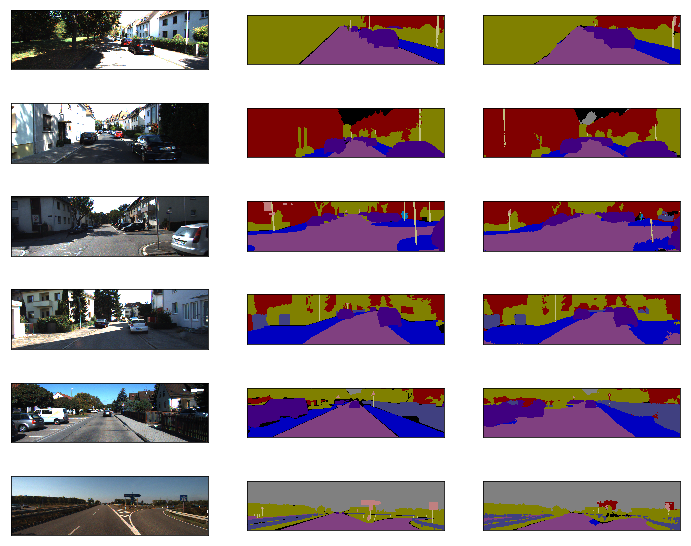

In [46]:
_, figs = plt.subplots(6, 3, figsize=(12, 10))
input_shape = ( 256,1024)
kitti_test  = KittiSegDataset(data_path,filenames_path,  False,True, input_shape, img_transforms)
test_data = DataLoader(kitti_test, 1, num_workers=4)

for i , data in enumerate(test_data):
  
    if i > 5: break

    test_dat, test_label = data[0],data[1]
    pred, label = predict(test_dat, test_label)
  
    figs[i, 0].imshow((Image.open(kitti_test.data_list[i])))
    figs[i, 0].axes.get_xaxis().set_visible(False)
    figs[i, 0].axes.get_yaxis().set_visible(False)
    figs[i, 1].imshow(cm[test_label.numpy()[0]])
    figs[i, 1].axes.get_xaxis().set_visible(False)
    figs[i, 1].axes.get_yaxis().set_visible(False)
    figs[i, 2].imshow(pred)
    figs[i, 2].axes.get_xaxis().set_visible(False)
    figs[i, 2].axes.get_yaxis().set_visible(False)
    
import time
start = time.time()
#long running
for i in range(100):
    pred, label = predict(test_dat, test_label)
#do something other
end = time.time()
print(end-start)

In [ ]:
_, figs = plt.subplots(1, 2, figsize=(8, 3))

plt.subplot(121)             # the first subplot in the first figure
plt.plot(range(3386),log_loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.subplot(122)             # the second subplot in the first figure
plt.plot(range(3386),log_IOU,range(3386),log_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training ACC and IOU')
plt.legend(['IoU','Accuracy'])

plt.show()